<div style='font-size: 3em'>SentiLens - Uncover reviews' hidden emotion</div>

__Prepared by:__ Tina Vu</br>
__Date:__ 20240208</br>

Employing aspect-based sentiment analysis (ABSA) to extract valuable feature insights from e-commerce product reviews, thereby empowering consumers to make more informed purchasing decisions and enhancing their overall user experience on the platform.

Utilizing manually annotated reviews for aspect sentiment analysis to extract aspects and predict sentiments from reviews. This enables consumers to obtain a condensed overview of sentiments related to various product features, eliminating the need to delve into an extensive array of reviews. As a result, the decision-making process becomes more streamlined and user-friendly.


## PROPOSED DATA SCIENCE SOLUTION
The project will be structured in phases:

- [X] **Phase 1:** Supervised ABSA
The goal of this phase is to be able to extract all aspect term and their sentment from the given review text. 

- [ ] **Phase 2:** Unsupervised sentiment aspect term extraction
I am hoping to utilize a larger unannotated dataset with rule-based aspect term annotations and re-train the model using this extended dataset in order to improve the model performance and to extend it to more domains (as suggested by <a href='https://aclanthology.org/W17-5224/'>Giannakopoulos et al., WASSA 2017</a>)

- [ ] **Phase 3:** App development
The end result of this project is to successfully develop an applications for:
  1. end-users to research e-commerce products' reviews
  2. sellers on the platform to learn more about their sales and customers' feedback
  3. e-commerce platform to improve product listing, seller managements

**Table of contents**<a id='toc0_'></a>    
- 1. [Data preparation](#toc1_)    
  - 1.1. [Tokenize sentence and aspect BIO encoding class](#toc1_1_)    
  - 1.2. [Load data](#toc1_2_)    
  - 1.3. [Inspect tagging issues](#toc1_3_)    
  - 1.4. [Merge conflict to negative & remove neutral](#toc1_4_)    
  - 1.5. [Convert df to HuggingFace datasets](#toc1_5_)    
  - 1.6. [Word features](#toc1_6_)    
- 2. [EDA](#toc2_)    
  - 2.1. [Word type distribution](#toc2_1_)    
  - 2.2. [Sentence length](#toc2_2_)    
  - 2.3. [Aspect & non-aspect part of speech (POS)](#toc2_3_)    
  - 2.4. [Aspect polarity & context words' sentiments](#toc2_4_)    
- 3. [Model performance class](#toc3_)    
- 4. [Random forest](#toc4_)    
- 5. [CRF](#toc5_)    
- 6. [DistilBERT](#toc6_)    
  - 6.1. [Model](#toc6_1_)    
  - 6.2. [Upsampling / downsampling](#toc6_2_)    
  - 6.3. [Downsampling](#toc6_3_)    
  - 6.4. [Upsampling](#toc6_4_)    
  - 6.5. [Model tuning](#toc6_5_)    
  - 6.6. [Start tuning](#toc6_6_)    
  - 6.7. [First BERT](#toc6_7_)    
  - 6.8. [Error analysis](#toc6_8_)    
    - 6.8.1. [Group by word token](#toc6_8_1_)    
    - 6.8.2. [Group by Tag ID](#toc6_8_2_)    
    - 6.8.3. [Sentence](#toc6_8_3_)    
  - 6.9. [Tuning BERT](#toc6_9_)    
    - 6.9.1. [Different datasets](#toc6_9_1_)    
    - 6.9.2. [Architecture](#toc6_9_2_)    
    - 6.9.3. [Tuning learning decay & batch size](#toc6_9_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [14]:
import os 
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0' # this setting is needed to run NN on my Mac

from datetime import datetime
import re
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from highlight_text import HighlightText, ax_text, fig_text


from nltk.tokenize import TreebankWordTokenizer

from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from seqeval.metrics import f1_score, classification_report
from sklearn.metrics import f1_score as sklearn_f1_score

# pip install torch==2.2.0 torchtext --index-url https://download.pytorch.org/whl/test/cpu
# pip install torch==2.3.0.dev20240121 # this does not work

# pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu # run this in CLI before running the notebook

# 1. <a id='toc1_'></a>[Data preparation](#toc0_)

The provided data (/data) has two columns:
- text: <str>
  Single review sentence
- aspects: <array<dict>>
  - term: <str> aspect term
  - polarity: <str> (positive, negative, neutral, and conflict) sentiment of the mentioned aspect term
  - from: <str> character index (in the sentence) of the aspect term's first character
  - to: <str> character index (in the sentence) of the aspect term's last character

We will aplied unified BIO tagging technique (<a href=''>more info</a>) to label our dataset for training. 
- First, we need to tokenize the review sentence into an array of words (tokens)
- Next, using the provided array of aspects, we iterate through the list of tokens (from prev step) and label them using the unified BIO (BIO + polarity) technique which combines aspect boundaries and aspect sentiment.
  Word boundaries:
  - B: indicates the 1st word in the aspect term
  - I: indicates the subsequent word in the aspect term
  - O: indicates words that are not part of any aspect term

  Aspect sentiment:
  - POS: positive
  - NEU: neutral
  - NEG: conflict

This BIO label technique is more effective in recognizing unigram and n-gram aspect terms comparing to a binary classification (whether a token is part of an aspect). By using a unified a approach, we can combine two tasks: aspect extraction and sentiment classification into one task.

## 1.1. <a id='toc1_1_'></a>[Tokenize sentence and aspect BIO encoding class](#toc0_)

Define a class to handle data transformation

In [15]:
class SentenceToken:
  '''
    SentenceToken

    This class takes care of word tokenize and tagging aspect entities
  '''
  def __init__(self, sentence, aspect_type=None, aspects=None, sentence_id=None):
    
    if sentence_id is not None:
      print(sentence_id)

    self.sentence_id = sentence_id
    self.sentence = sentence.replace(u"\u00A0", " ").replace(u'\xa0',' ') # replace unicode <space> character
                            
    self.aspect_bio_tags = None
    self.unified_aspect_bio_tags = None
    self.token_span = None
    self.space_pre_token = None

    # Tokenize sentence
    self.__tokenize_sentence(self.sentence)

    if aspect_type == 'dict':
      self.set_aspect_tagging_from_dict(aspects)
    elif aspect_type == 'bio':
      self.set_aspect_bio_tags(aspects)
    elif aspect_type == 'unified bio':
      self.set_aspect_unified_bio_tags(aspects)
  
  def __tokenize_sentence(self, sentence):
    '''
    __tokenize_sentence

    Break sentence into word token span
    '''
    token_span = list(TreebankWordTokenizer().span_tokenize(sentence))
    
    self.token_span = token_span
    self.space_pre_token = [True if sentence[k[0]-1:k[0]] == ' ' else False for i,k in enumerate(token_span)]

  def set_aspect_tagging_from_dict(self, aspects):
    '''
    set_aspect_tagging_from_dict

    Calculate & assign aspect entities to token given an array of aspects (term, start_index, to_index, and polarity)
    '''
    polarity_map = {'positive':'POS'
              ,'negative': 'NEG'
              ,'conflict': 'CON'
              ,'neutral': 'NEU'}
    
    bio_tags = ['O'] * len(self.token_span)
    unified_bio_tags = bio_tags

    for x in aspects:
      if x['term'] != '':
        aspect_from = int(x['from'])
        aspect_to = int(x['to'])
        polarity = '-' + polarity_map[x['polarity']] # Get encoded polarity

        # I am not comparing the exact start/ end of a word token with the aspect term from/to idx, 
        # because some aspects are marked in the middle of a token, 
        # such as unaligned punctuation strategy with the selected tokenzier (e.g. I don't like these :abc, acd. - "abc" is aspect, token is: ":abc")
        aspect_from_index = [i for i, v in enumerate(self.token_span) if (v[0] <= aspect_from) & (v[1] >= aspect_from)][0] # Get token index where aspect term start idx is between token start idx & token end idx
        aspect_to_index = [i for i, v in enumerate(self.token_span) if (v[0] <= aspect_to) & (v[1] >= aspect_to)][0] # similar to the above, but this time is aspect term end idx

        # Get aspect range
        aspect_length = aspect_to_index - aspect_from_index

        # replace "O" tags where token idx is between aspect token idx range with "BI"
        bio_tags = bio_tags[:aspect_from_index] + ['B'] + ['I'] * (aspect_length) + bio_tags[aspect_to_index+1:] # no polarity
        unified_bio_tags = unified_bio_tags[:aspect_from_index] + ['B' + polarity] + ['I'+ polarity] * (aspect_length) + unified_bio_tags[aspect_to_index+1:] # unified with polarity

    self.set_aspect_bio_tags(bio_tags)
    self.set_aspect_unified_bio_tags(unified_bio_tags)

  def rebuild_sentence_from_token(self):
    '''
    rebuild_sentence_from_token

    Return sentence built from computed token spans
    '''
    return ''.join([(' ' if self.space_pre_token[i] else '') + self.sentence[k[0]:k[1]] for i, k in enumerate(self.token_span)])
 
  def set_aspect_bio_tags(self, aspect_bio_tags):
    '''
    set_aspect_bio_tags

    Setter method to set aspect_unified_bio_tags and aspect_bio_tags
    '''
    self.aspect_bio_tags = aspect_bio_tags
    self.aspect_unified_bio_tags = aspect_bio_tags

  def set_aspect_unified_bio_tags(self, aspect_unified_bio_tags):
    ''''
    set_aspect_unified_bio_tags
    
    Setter method to set aspect_unified_bio_tags and aspect_bio_tags
    '''
    self.aspect_unified_bio_tags = aspect_unified_bio_tags
    self.aspect_bio_tags = [k[0:1] for k in aspect_unified_bio_tags]

  def get_tokens(self):
    '''
    get_tokens()
    Return an array of sentence word tokens
    '''
    return [self.sentence[k[0]:k[1]] for k in self.token_span]
  
  def check_rebuild_sentence_from_token(self):
    '''
    check_rebuild_sentence_from_token()

    This is a test / debugger function.
    This help validating if we have computed the sentence to token properly and whether we can re-compute the exact sentence from information stored.
    '''
    return re.sub(r'\s+', ' ',self.sentence.strip()) == self.rebuild_sentence_from_token().strip()
  
  def check_rebuild_aspect_terms(self, aspect_dict):
    '''
    check_rebuild_aspect_terms(aspect_dict)

    This is a test / debugger fucntion. 
    This help validate if we have compute the correct aspect terms as given by the aspect dict

    INPUT:
    aspect dict: array of aspect dictionaries in the following format
      [{'term': 'storage', 
       'polarity': 'positive', 
       'from': '14', 
       'to': '21'}]
    '''
    aspect_dict = sorted(aspect_dict, key=lambda d: int(d['from']))
    aspect_input = [k['term'].replace(u"\u00A0", " ").replace(u'\xa0',' ') for k in aspect_dict if k['term'] != '' ]
    aspect_computed = []
    aspect = ''
    
    for i,k in enumerate(self.aspect_bio_tags):
      token = self.sentence[self.token_span[i][0]:self.token_span[i][1]]
      
      if k == 'B':
        if (self.aspect_bio_tags[i-1] == 'B' if i > 0 else False):
          aspect_computed.append(aspect)
        aspect = token
      elif k == 'I':
        aspect += ' ' * ((self.token_span[i][0] -  self.token_span[i-1][1]) if i > 0 else 0) + token
      
      if (aspect != '') & ((k == 'O') or (i == (len(self.aspect_bio_tags) - 1))):
          aspect_computed.append(aspect)
          aspect = ''

    return [aspect_input == aspect_computed, aspect_input, aspect_computed]

  def __str__(self):
    return self.rebuild_sentence_from_token()


## 1.2. <a id='toc1_2_'></a>[Load data](#toc0_)

In [38]:
def reload_Data():
  df_train = pd.read_json('data/laptop/train.json')
  # First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
  # We have removed 12 duplicated records in our training dataset
  df_train.drop_duplicates(subset='text', inplace=True)
  print('df_train shape: ', df_train.shape)

  df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
  print('df_val shape: ', df_val.shape)

  # Build sentence token class for each record
  df_train['sentence_token'] = df_train.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
  # Rebuild sentence from computed tokens and validate if we have the same content as the original text to ensure tokenizer works as expected
  df_train['sentence_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
  # Get aspect check object to validate if the aspects were tagged correctly
  df_train['aspect_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)
  df_train['aspect_check_TF'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects'])[0], axis=1)
  # These two are the main results that we will need to use for our training data
  df_train['tokens'] = df_train.apply(lambda x: x['sentence_token'].get_tokens(), axis=1)
  df_train['tags'] = df_train.apply(lambda x: x['sentence_token'].aspect_unified_bio_tags, axis=1)

  # Redo for validation set (actually this will be use as a test set)
  df_val['sentence_token'] = df_val.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
  df_val['sentence_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
  df_val['aspect_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)
  df_val['aspect_check_TF'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects'])[0], axis=1)
  df_val['tokens'] = df_val.apply(lambda x: x['sentence_token'].get_tokens(), axis=1)
  df_val['tags'] = df_val.apply(lambda x: x['sentence_token'].aspect_unified_bio_tags, axis=1)
  return df_train, df_val

In [39]:
df_train, df_test = reload_Data()
print('# of df_train records having tokenizing issues: ', len(df_train[df_train['sentence_check']==False]))
print('# of df_train records having aspect bio tagging issues: ', len(df_train[df_train['aspect_check_TF']==False]))
print('# of df_test records having tokenizing issues: ', len(df_test[df_test['sentence_check']==False]))
print('# of df_test records having aspect bio tagging issues: ', len(df_test[df_test['aspect_check_TF']==False]))

Here we noticed that, training set has 36 records that the computed aspect tags did not produce the same results as the given aspects. Similarly, there are 9 of those records in test (validation) set.

## 1.3. <a id='toc1_3_'></a>[Inspect tagging issues](#toc0_)

We would like to inspect all of these "false" tags to see what the issues were and whether we can improve the SentenceToken class further.

In [40]:
print(df_train[df_train['aspect_check_TF']==False].index)

In [41]:
num = 2606

print(df_train.loc[num]['aspects'])
print(df_train.loc[num]['text'])
print(df_train.loc[num]['aspect_check'])
print(df_train.loc[num]['tokens'])

Most of the tagging issues due to word that are not separated properly from special characters/ punctuations. The issue is unavoidable in practice as reviews may not adherent to perfect grammar.

I have tried to fix this issues to have 100% accuracy with further token breakdown to match the specified aspect tokens, however, this can break some of the standard logics for word tokenizer and further modelling. 

Therefore, I decided to include a whole token where the aspect may start or end, even if the index is in the middle of token, which may results with aspect tokens that could include extra characters than planned. This is the risk we will accept for this approach, and we can perform a cleaning process to remove these extra characters during implementation with actual use cases.

This was an iterative process to come up with the best way to transform the given dataset. Some of the other changes I have made were that I identified some "annotation mistake" where the users missed a character in an aspect term, which presented an abitrary mistake, therefore, I updated the dataset to recover a 5-10 more records.

## 1.4. <a id='toc1_4_'></a>[Merge conflict to negative & remove neutral](#toc0_)

We have very small amount of aspects (<20 records, <1%) that are tagged as "Conflict" in the dataset. Additionally, we are only interested in Positive / Negative aspects, I decided to merge "Conflict" with negative (given conflict aspects are tending more towards negative than positive, the positive is mainly come from personal "acceptance of the given situation").

In [42]:
Counter(sum(df_train['tags'],[]))

Counter({'O': 47537,
         'B-POS': 987,
         'B-NEG': 862,
         'B-NEU': 461,
         'I-NEG': 461,
         'I-POS': 390,
         'I-NEU': 312,
         'B-CON': 45,
         'I-CON': 21})

In [43]:
# Get samples of sentences that have "conflict" aspects
conflicts_df = df_train[df_train['tags'].apply(lambda x: sum([1 if tag[2:] == 'CON' else 0 for tag in x ])) > 0]
num = 5
print(conflicts_df.iloc[num]['text'])
print(conflicts_df.iloc[num]['aspects'])


For example, in this sentence, the aspect is "screen", and it is "small" which is negative. While the users can make it work for them, the aspect itself is still negative.

In [44]:
df_train['tags'] = df_train['tags'].apply(lambda x: [tag[:2] + 'NEG' if tag[2:] == 'CON' else tag for tag in x ])
df_test['tags'] = df_test['tags'].apply(lambda x: [tag[:2] + 'NEG' if tag[2:] == 'CON' else tag for tag in x])

## 1.5. <a id='toc1_5_'></a>[Convert df to HuggingFace datasets](#toc0_)

In [45]:
import datasets
from datasets import Dataset, DatasetDict, Features, Sequence, Value, ClassLabel

Convert aspect tag to id

In [46]:
# Generate list of unique aspect tags
tags = list(set(sum(df_train['tags'],[])))
tags.sort()

tag2idx = {k:i for i,k in enumerate(tags)}
idx2tag = {i:k for i,k in enumerate(tags)}

# Convert aspect tag text to ids
df_train['tags_idx'] = df_train['tags'].apply(lambda x: [tag2idx[k] for k in x])
df_test['tags_idx'] = df_test['tags'].apply(lambda x: [tag2idx[k] for k in x])

In [47]:
idx2tag

{0: 'B-NEG',
 1: 'B-NEU',
 2: 'B-POS',
 3: 'I-NEG',
 4: 'I-NEU',
 5: 'I-POS',
 6: 'O'}

In [48]:
tags

['B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O']

Convert pandas to HuggingFace datasets

In [49]:
# Split train into train & validation set
df_train_ori, df_val = train_test_split(df_train, test_size=0.3, random_state=42,)

In [50]:
# Define dataset features
features = Features({'tokens': Sequence(Value(dtype='string', id=None)),
                    'tags_idx': Sequence(ClassLabel(names=tags))
                    })

tds = Dataset.from_pandas(df_train_ori[['tokens','tags_idx']], features=features, preserve_index=False)
vds = Dataset.from_pandas(df_val[['tokens','tags_idx']], features=features,  preserve_index=False)
tsds = Dataset.from_pandas(df_test[['tokens','tags_idx']], features=features, preserve_index=False)

ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds
ds['test'] = tsds

print(ds)

Check for total counts per aspect type in each data split

## 1.6. <a id='toc1_6_'></a>[Word features](#toc0_)

Here we will populate some word features for each token (word) in the sentence, such as:
- word
- stemming / lemming versions of word
- part of speech (POS) of word
- words sentiment lexicon
- context words within a pre-defined window (5 words surrounding the token)
- context words stemming/ lemming
- context words POS
- context words sentiment lexicon
- ...

The list is not exhaustive, and is an iterative process as we perform EDA and go back and refining/ adding more features.

In [51]:
import nltk
from nltk.corpus import stopwords, opinion_lexicon
import string

# Load positive and negative words from the opinion lexicon
POSITIVE_WORDS = set(opinion_lexicon.positive())
NEGATIVE_WORDS = set(opinion_lexicon.negative())
# Load common stop words in english
EN_STOP_WORDS = set(stopwords.words('english'))

In [52]:
# Function to convert sentences into features
def word2features(sent, word_idx, backward_window_size=5, forward_window_size=5): 
    word = sent[word_idx]

    _, pos = zip(*nltk.pos_tag([x for x in sent]))

    tag_sentiment = lambda word: 'POS' if word in POSITIVE_WORDS else 'NEG' if word in NEGATIVE_WORDS else 'NEU'
    features = {
        'word.lower()': word.lower(), # word
        'word.index()': word_idx,
        'word.reverseindex()': len(sent) - 1 - word_idx, # reverse index - nth word from end of sentence
        'word.pos': pos[word_idx],
        'word.opinionlexicon': tag_sentiment(word.lower()),
        'word.isstopword()': word.lower() in EN_STOP_WORDS,
        'word[-3:]': word[-3:], # last 4 char
        'word[-2:]': word[-2:], # last 3 char - in case of -ing, -ion, etc.
        'word.isupper()': word.isupper(), # is the word in upper case
        'word.istitle()': word.istitle(), # is the first letter of the word in upper case
        'word.isdigit()': word.isdigit(), # is the word full of digit
        'word.ispunctuation()': word.lower() in string.punctuation, # is punctuation
    }

    if word_idx > 0:
        for k in range(1, min(backward_window_size, word_idx)+1):
            prev_word = sent[word_idx - k]
            prev_pos = pos[word_idx - k]
            
            features.update({
                f'-{k}:word.lower()': prev_word.lower(),
                f'-{k}:word.pos': prev_pos,
                f'-{k}:word.opinionlexicon': tag_sentiment(word.lower()),
                f'-{k}:word.isstopword()': prev_word in EN_STOP_WORDS,
                f'-{k}:word.istitle()': prev_word.istitle(),
                f'-{k}:word.isupper()': prev_word.isupper(),
                f'-{k}:word.ispunctuation()': prev_word.lower() in string.punctuation, # is punctuation
            })
    else:
        features['BOS'] = True  # Beginning of sentence

    if word_idx < len(sent) - 1:
        for k in range(1, min(forward_window_size, len(sent) - word_idx - 1)+1):
            next_word = sent[word_idx + k]
            next_pos = pos[word_idx + k]

            features.update({
                f'+{k}:word.lower()': next_word.lower(),
                f'+{k}:word.pos': next_pos,
                f'+{k}:word.opinionlexicon': tag_sentiment(word.lower()),
                f'+{k}:word.isstopword()': next_word in EN_STOP_WORDS,
                f'+{k}:word.istitle()': next_word.istitle(),
                f'+{k}:word.isupper()': next_word.isupper(),
                f'+{k}:word.ispunctuation()': next_word.lower() in string.punctuation, # is punctuation
            })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Function to convert sentences into feature sequences
def sent2features(sent, backward_window_size=5, forward_window_size=5):
    return [word2features(sent, i, backward_window_size, forward_window_size) for i in range(len(sent))]

def get_features(example):
    example['word_features'] = [ sent2features(sent) for sent in example['tokens']]
    return example

In [53]:
ds_features = ds.map(get_features, batched=True)

Map:   0%|          | 0/2125 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

# 2. <a id='toc2_'></a>[EDA](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Word type distribution](#toc0_)

In [54]:
# Convert aspect idx to aspect aspect text
def create_tag_names(batch):
    return {"tags": [ds["train"].features["tags_idx"].feature.int2str(idx) for idx in batch["tags_idx"]]}

ds = ds.map(create_tag_names)

Map:   0%|          | 0/2125 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [55]:
# Perform aspect type counts per each dataset split
split2freqs = defaultdict(Counter)
for split, dataset in ds.items():
    for row in dataset["tags"]:
        for tag in row:
          split2freqs[split][tag] += 1
                
word_type_distribution = pd.DataFrame.from_dict(split2freqs, orient="index")
word_type_distribution

,O,B-NEG,I-NEG,B-POS,I-POS,B-NEU,I-NEU
train,33034,582,315,675,232,304,190
validation,14503,325,167,312,158,157,122
test,10709,144,89,340,162,169,184


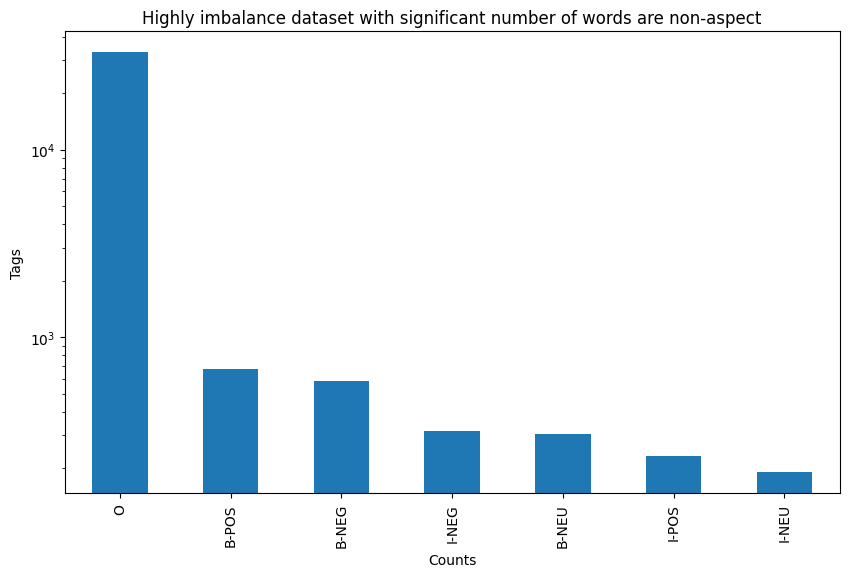

In [56]:

# Sort the DataFrame by values in ascending order
df_sorted = word_type_distribution.loc['train'].squeeze().sort_values(ascending=False)

# Plotting
ax = df_sorted.plot(kind='bar', figsize=(10, 6), logy=True)
plt.title('Highly imbalance dataset with significant number of words are non-aspect')
plt.xlabel('Counts')
plt.ylabel('Tags')
plt.show()

This word distribution shows that % of word tokens are non-aspect token suggesting that the model training will face imbalance data challenges.

In [58]:
# Perform aspect type counts per each dataset split
split2freqs = defaultdict(Counter)
for split, dataset in ds.items():
    for row in dataset["tags"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient="index")

,NEG,POS,NEU
train,582,675,304
validation,325,312,157
test,144,340,169


We also have a slightly different distribution of aspect polarity between training + validation datasets and test dataset. Inspecting the model predictions may reveal some of the model weaknesses such as whether the model just learn the location of the aspect, and memorize the words which makes it less effective in generalizing.

## 2.2. <a id='toc2_2_'></a>[Sentence length](#toc0_)

It is important to understand the distribution of the sentence length as most techniques may require setting the max number of tokens for model inputs, as well as, certain algorithms may only support upto only a certain lengths.

In [59]:
review_length = ds["train"].to_pandas()['tokens'].apply(lambda x: len(x))

fig = px.ecdf(review_length, marginal="histogram")
fig. update_layout(showlegend=False,
                   xaxis_title="# of words in reviews",
                   yaxis_title="Review counts")
fig.show()

95% records have <= 35 words. We should be in the "safe zone" to apply any alogrithms.

## 2.3. <a id='toc2_3_'></a>[Aspect & non-aspect part of speech (POS)](#toc0_)

We wuold like to see if tag of speech play a role in helping us detecting aspect and non-aspect words. Since aspects are normally topics that people talk about. Generally, aspects should have a high chance of being a noun.

In [60]:
def features2df(sent, sent_idx):
  sent_df = pd.DataFrame(list(sent))
  sent_df['sentence_idx'] = sent_idx

  return sent_df

In [61]:
df_features = ds_features['train'].to_pandas()['word_features']
df_features = pd.concat([features2df(sent, i) for i, sent in enumerate(df_features)], ignore_index=True)
df_features['tags'] = [idx2tag[tag] for sent in ds_features['train'].to_pandas()['tags_idx'] for tag in sent ]
df_features['is_aspect'] = df_features['tags'].apply(lambda x: 'aspect' if x != 'O' else 'non-aspect')
df_features['is_noun_pos'] = df_features['word.pos'].apply(lambda x: 'noun' if x.startswith('NN') else 'not noun')

In [62]:
# Count words per each POS per each tag
pos_counts = df_features.groupby(['is_aspect', 'is_noun_pos']).agg(word_count=pd.NamedAgg(column='is_aspect', aggfunc='count')).reset_index()

# Separate data to aspect & non-aspect words
aspect_pos_counts = pos_counts[pos_counts['is_noun_pos'] == 'noun']
non_aspect_pos_counts = pos_counts[pos_counts['is_noun_pos'] == 'not noun']

# Plot POS per word type
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
# Aspects
fig.add_trace(go.Pie(labels=aspect_pos_counts['is_aspect'], values=aspect_pos_counts['word_count'], name="noun"),
              1, 1)
# Non-aspects
fig.add_trace(go.Pie(labels=non_aspect_pos_counts['is_aspect'], values=non_aspect_pos_counts['word_count'], name="not noun"),
              1, 2)

fig.update_traces(hole=.4, direction='clockwise', textinfo='label+percent', textposition='inside',showlegend = False)
fig.update_layout(
    width=1000,
    height=500,
    title_text="A noun in a sentence has a higher chance being part of an aspect time than non-noun.",
    annotations=[dict(text='Noun', x=0.2, y=0.5, font_size=16, showarrow=False),
                 dict(text='Not noun', x=0.828, y=0.5, font_size=16, showarrow=False)])
fig.show()

## 2.4. <a id='toc2_4_'></a>[Aspect polarity & context words' sentiments](#toc0_)

In [63]:
opnion_lexicon_columns = [x for x in list(df_features.columns) if re.match('.*opinionlexicon.*', x)]
opnion_lexicon_columns.remove('word.opinionlexicon')

df_aspects = df_features[df_features['tags'] != 'O'].copy()
df_opnions = df_aspects[opnion_lexicon_columns]
df_aspects['POS_context'] = df_opnions.map(lambda cell: bool(re.match('POS', str(cell)))).max(axis=1)
df_aspects['NEG_context'] = df_opnions.map(lambda cell: bool(re.match('NEG', str(cell)))).max(axis=1)
df_aspects['NEU_context'] = df_opnions.map(lambda cell: bool(re.match('NEU', str(cell)))).max(axis=1)
df_aspects['sentiment'] = df_aspects['tags'].apply(lambda x: x.split('-')[1])

In [65]:
sentiment_context_summary = df_aspects.groupby('sentiment')[['POS_context','NEG_context']].agg('mean').sort_values(by=['POS_context'])
sentiment_context_summary = sentiment_context_summary.multiply(100)
fig = px.bar( sentiment_context_summary.astype(float), x=sentiment_context_summary.index, y=['POS_context', 'NEG_context'],
             title='% aspect words contains positive, negative context words by Sentiment',
             labels={'value': '% aspect words', 'variable': '% aspect words', 'sentiment': 'Aspect'},
             barmode='group')

# Show the plot
fig.show()

# 3. <a id='toc3_'></a>[Model performance class](#toc0_)

This class is created so that we can keep track of all models' performance.
We will compute two metrics for all of the models:
- macro f1 score: this gives some information on how the model performs on token level
- coNLL f1 score: this is a much stricter metric that ensure n-gram aspects are labelled accurately

In [87]:
class ModelPerformanceLog:
  
  def __init__(self, y_true):
    # Initialization setup a variable to store true labels
    self.y_true = y_true
    self.log = {}
    self.bert_epoch_history = pd.DataFrame()

  def add_model_performance(self, model_name, y_pred, model=None): 
    # as each model finished training, we will add model name and its predictions
    # then performance metrics will be computed against the same set of true labels
    sklearn_f1_score, f1, clf_report = self.__calculate_metrics(y_pred)

    model_perf = {'y_pred': y_pred
                  ,'model': model
                  ,'sklearn_f1_score': sklearn_f1_score.round(2)
                  ,'f1': f1.round(4)
                  ,'report': clf_report
                  }
    
    self.log[model_name] = model_perf

  def __calculate_sklearn_f1(self, y_pred):
    y_pred = sum(y_pred,[])
    y_true = sum(self.y_true,[])
    return sklearn_f1_score(y_true, y_pred, average='macro', zero_division=0) # macro f1

  def __calculate_metrics(self, y_pred):
    return self.__calculate_sklearn_f1(y_pred), f1_score(self.y_true, y_pred), classification_report(self.y_true, y_pred, zero_division=0) # CORNELL F1

  def get_logs(self):
    logs_df = pd.DataFrame(list(self.log.values()), index=self.log.keys())
    return logs_df[['sklearn_f1_score', 'f1']]
  
  def add_bert_training_epoch_history(self, model_name, epoch_history_df):
    epoch_history_df['Model'] = model_name
    self.bert_epoch_history = pd.concat([self.bert_epoch_history, epoch_history_df])
    

In [88]:
y_val = ds['validation'].to_pandas()['tags_idx']
y_val = [[idx2tag[tag] for tag in sent] for sent in y_val] # Replace tag_idx to tag

modelPerformanceLog = ModelPerformanceLog(y_val)

# 4. <a id='toc4_'></a>[Random forest](#toc0_)

First, we will apply a basic machine learning algorithm to establish a baseline.

In [89]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [90]:
def features2df(sent, sent_idx):
  sent_df = pd.DataFrame(list(sent))
  sent_df['sentence_idx'] = sent_idx

  return sent_df

In [91]:
def tags2df(tags, sent_idx):
  tags_df = pd.DataFrame({'tags': tags})

  tags_df['sentence_idx'] = sent_idx
  return tags_df

In [92]:
def random_forest_data_prepare(ds, one_hot_encoder=None):
  X_train = ds.to_pandas()['word_features']
  X_train = pd.concat([features2df(sent, i) for i, sent in enumerate(X_train)], ignore_index=True)

  X_train.replace(True,1, inplace=True)
  X_train.replace(False,0, inplace=True)

    # Fill NaN values in object-type columns with a 'missing'
  object_columns = X_train.select_dtypes(include=['object']).columns
  X_train[object_columns] = X_train[object_columns].fillna(value='missing')

  # Fill the rest NaN with -1, since most of missing features are boolean
  X_train = X_train.fillna(-1)

  # We renove all categorical columns that are not POS, or sentiment lexicon + nth_sentence which the number of the sentence we we use to string back the data at the end, but is not needed for training
  drop_cols = [x for x in list(X_train.columns) if re.match('(.*word\.lower\(\))|(.*word\[-\d\:])', x)] # word columns
  X_train = X_train.drop(columns=drop_cols, axis=1)

    # Perform one-hot-encoder on the reamining columns
  if one_hot_encoder is None: # This is to make sure we use the same one-hot-encoder for both train & test split (avoiding data leakage)
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')  # 'drop' parameter is optional, set to 'first' to avoid multicollinearity
    encoded_data = one_hot_encoder.fit_transform(X_train.select_dtypes(include=['object']))

  else: # when we perform data prep for test data, we can reuse the one-hot-encoder used during training data preparation
    encoded_data = one_hot_encoder.transform(X_train.select_dtypes(include=['object']))

  # Re-added one-hot-encoding data back to the main dataframe
  df_encoded = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(X_train.select_dtypes(include=['object']).columns))
  X_train = pd.concat([X_train, df_encoded], axis=1)

  # Dropped all the categorical features that have already been one-hot-encoded
  X_train.drop(columns=X_train.select_dtypes(include=['object']).columns, inplace=True)

  y_train =  pd.concat([tags2df(sent, i) for i, sent in enumerate(ds.to_pandas()['tags_idx'])], ignore_index=True)# sum(ds.to_pandas()['tags_idx'], [])
  return X_train, y_train, one_hot_encoder


In [93]:
X_train, y_train, one_hot_encoder = random_forest_data_prepare(ds_features['train'])
X_val, y_val, _ = random_forest_data_prepare(ds_features['validation'], one_hot_encoder)

/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning:

Found unknown categories in columns [3, 5, 7, 9] during transform. These unknown categories will be encoded as all zeros



In [94]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_train_scaled = scaler.fit_transform(X_train.drop('sentence_idx', axis=1))
X_val_scaled = scaler.transform(X_val.drop('sentence_idx', axis=1)) # Double check why we are seeing more columns in test????

In [95]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=5, random_state=42)
rf_classifier.fit(X_train_scaled, y_train['tags'])

y_pred_rf = rf_classifier.predict(X_val_scaled)

In [96]:
# Add back to validation set to get sentence id
y_val['predict'] = y_pred_rf 

# Collapse back to the required format
y_pred_rf = y_val.groupby('sentence_idx')['predict'].agg(lambda x: x.tolist())

# Convert to name lablel
y_pred_rf = [[idx2tag[tag] for tag in sent] for sent in y_pred_rf]

modelPerformanceLog.add_model_performance('random forest',y_pred_rf)
modelPerformanceLog.get_logs()

,sklearn_f1_score,f1
random forest,0.14,0.0


# 5. <a id='toc5_'></a>[CRF](#toc0_)

In [97]:
from sklearn_crfsuite import CRF

In [98]:
X_train = ds_features['train'].to_pandas()['word_features']
y_train = ds_features['train'].to_pandas()['tags_idx']
y_train = [[idx2tag[tag] for tag in sent] for sent in y_train]

X_val = ds_features['validation'].to_pandas()['word_features']

In [99]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs',
                max_iterations=100,
                c1=0.5,
                c2=0.05)

# There is this error existing with this library: 'CRF' object has no attribute 'keep_tempfiles'
# which has not been resolved and we can bypass it using this trick.
try:
  crf_model.fit(X_train, y_train)
except AttributeError:
  pass

In [100]:
y_pred_crf = crf_model.predict(X_val)

In [104]:
modelPerformanceLog.add_model_performance('crf',y_pred_crf)
modelPerformanceLog.get_logs()

,sklearn_f1_score,f1
random forest,0.14,0.0
crf,0.14,0.0


# 6. <a id='toc6_'></a>[DistilBERT](#toc0_)

In [2]:

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy

from transformers import AutoConfig, DistilBertConfig, AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.distilbert.modeling_distilbert import DistilBertModel
from transformers.models.distilbert.modeling_distilbert import DistilBertPreTrainedModel

device = torch.device('mps') # This is required for Mac

2024-02-07 23:51:48.523705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 6.1. <a id='toc6_1_'></a>[Model](#toc0_)

In [106]:
class DistilBertForABSA(DistilBertPreTrainedModel):
  config_class = DistilBertConfig

  def __init__(self, config, architecture, loss_token_weights):
    super().__init__(config)
    # Roberta body
    self.num_labels = config.num_labels
    self.distilbert = DistilBertModel(config)
    self.architecture = architecture
    self.loss_token_weights = loss_token_weights

    # Classification head
    self.dropout = nn.Dropout(config.dropout)
    

    if architecture == 'additional_linear':
        # Additional layer
        self.additional_linear = nn.Linear(config.hidden_size, 10)
        self.additional_dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(10, config.num_labels)
        

    elif architecture == 'lstm':
        self.lstm = nn.LSTM(config.hidden_size, 30, bidirectional=True)
        self.additional_dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(60, config.num_labels)

    else:
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    # Load and initialize weights from pretrained
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        
    # Use model body to get encoder representations
    outputs = self.distilbert(input_ids, attention_mask=attention_mask,
                                **kwargs)
    
    # Apply classifier to encoder representation (model head)
    sequence_output = self.dropout(outputs[0])

    if self.architecture == 'additional_linear':
        # Additional layer
      additional_linear_output = self.additional_linear(sequence_output)
      logit_input = self.additional_dropout(additional_linear_output)
    elif self.architecture == 'lstm':
      lstm_output, _ = self.lstm(sequence_output)
      logit_input = self.additional_dropout(lstm_output)
    else:
      logit_input = sequence_output
    
    logits = self.classifier(logit_input)
    
    # Calculate losses
    loss = None
    if labels is not None:
        if len(self.loss_token_weights) > 0:
          # loss_weights = torch.tensor(self.loss_token_weights, dtype=torch.float16).to(device) # This kills the kernel, not sure why
          loss_fct = nn.CrossEntropyLoss()
        else:
          loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
    # Return model output object
    return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)
    

## 6.2. <a id='toc6_2_'></a>[Upsampling / downsampling](#toc0_)

Since our dataset is very imbalance which a super higher portion of non-aspect term, it will benefit some sampling techniques. However, unline simple machine learning problem, we are dealing with sentence-level dataset, we need to maintain the whole sentence sequence in our dataset. We need to find samplings trategies that can perform sentence level resampling which may be much trickier.

## 6.3. <a id='toc6_3_'></a>[Downsampling](#toc0_)

For downsampling, I decided to follow a simple strategy by dropping out 1/3 of sentences that do not have any aspect in their sentence. 

In [107]:
from random import randint
df_train_ori['aspect_token_counts'] = df_train_ori['tags'].apply(lambda x: sum([1 for tag in x if tag != 'O']))
df_train_ori['select'] = df_train_ori['aspect_token_counts'].apply(lambda x: randint(0,2) if x == 0 else 1)

downsample_df_train = df_train_ori[df_train_ori['select']==1].copy()

In [108]:
# Perform aspect type counts per each dataset split
split2freqs = defaultdict(Counter)

for row in df_train_ori["tags"]:
    for tag in row:
        if tag.startswith("B"):
            tag_type = tag.split("-")[1]
            split2freqs['original'][tag] += 1
        elif tag == 'O':
            split2freqs['original'][tag] += 1

for row in downsample_df_train["tags"]:
    for tag in row:
        if tag.startswith("B"):
            tag_type = tag.split("-")[1]
            split2freqs['down'][tag] += 1
        elif tag == 'O':
            split2freqs['down'][tag] += 1
                
tags_per_down_ds = pd.DataFrame.from_dict(split2freqs, orient="index")

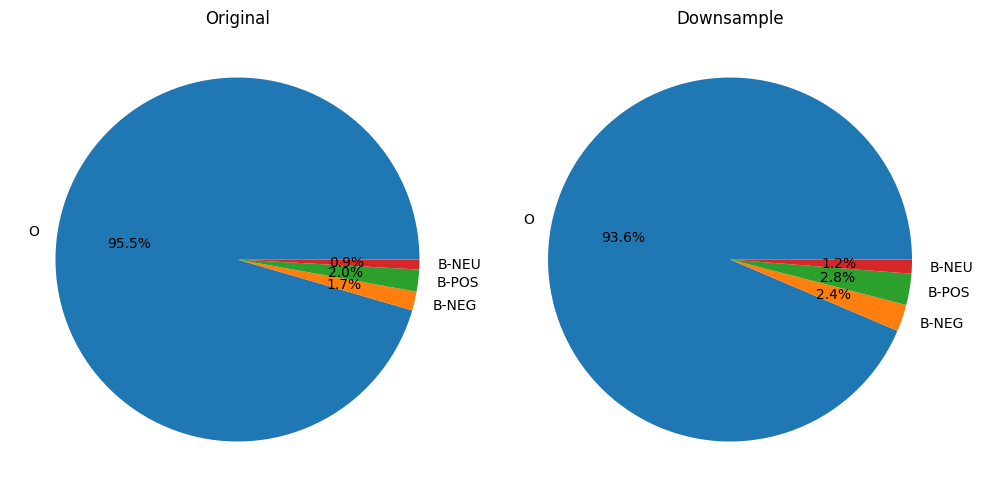

In [109]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(tags_per_down_ds.loc['original'], labels=tags_per_down_ds.columns, autopct='%1.1f%%')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.pie(tags_per_down_ds.loc['down'], labels=tags_per_down_ds.columns, autopct='%1.1f%%')
plt.title('Downsample')

plt.tight_layout()
plt.show()


In [110]:
import copy

downsample_tds = Dataset.from_pandas(downsample_df_train[['tokens','tags_idx','tags']], features=ds['train'].features, preserve_index=False)

downsample_ds = copy.copy(ds)

downsample_ds['train'] = downsample_tds


print(downsample_ds)
print(ds)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 1391
    })
    validation: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 911
    })
    test: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 800
    })
})
DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 2125
    })
    validation: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 911
    })
    test: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 800
    })
})


## 6.4. <a id='toc6_4_'></a>[Upsampling](#toc0_)

I followed <a href='https://aclanthology.org/2022.naacl-main.156.pdf'>Wang's Sentence-Level Resampling for Named Entity Recognition</a> to re-balance the dataset for training. I decided to experiment with sCR strategy which is pretty much similar to inverse document frequency on a token level that looks at counts of aspect and rarity of an aspect type.

In [83]:
from math import log,sqrt, ceil

def custom_sampling_based_on_score(df, method):
  # Get stats of the class distribution of the dataset
  labels = sum(df['tags'],[])
  num_tokens = len(labels)
  ent = [label[2:] for label in labels if label != 'O']
  stats = Counter(ent)
  for key in stats:
      #Use frequency instead of count
      stats[key] = stats[key]/num_tokens

  if method not in ['sc','sCR','sCRD','nsCRD']:
    raise ValueError("Unidentified Resampling Method")

  custom_sampled_df = pd.DataFrame(columns=df.columns)
  
  for sen in range(len(df)):
    sampled_data = [] 
    # Resampling time can at least be 1, which means sentence without 
    # entity will be reserved in the dataset  
    rsp_time = 1
    sen_len = len(df.iloc[sen]['tags'])
    ents = Counter([label[2:] for label in df.iloc[sen]['tags'] if label != 'O'])
          # Pass if there's no entity in a sentence
    
    
    if ents:
      for ent in ents.keys():
        # Resampling method selection and resampling time calculation, 
        # see section 'Resampling Functions' in our paper for details.
        if method == 'sc':
          rsp_time += ents[ent]
        if method == 'sCR' or method == 'sCRD':
          weight = -log(stats[ent],2)
          rsp_time += ents[ent]*weight
        if method == 'nsCRD':
          weight = -log(stats[ent],2)
          rsp_time += sqrt(ents[ent])*weight
        if method == 'sCR':
          rsp_time = sqrt(rsp_time)
        if method == 'sCRD' or method == 'nsCRD':
          rsp_time = rsp_time/sqrt(sen_len)
      # Ceiling to ensure the integrity of resamling time
      rsp_time = ceil(rsp_time) 
    
    for t in range(rsp_time):
      for token in range(sen_len):
        sampled_data.append(df.iloc[sen].to_dict())


    custom_sampled_df = pd.concat([custom_sampled_df, pd.DataFrame(sampled_data)], ignore_index=True)

  return custom_sampled_df

In [84]:
# Use the custom sampling method
sCR_df = custom_sampling_based_on_score(df_train_ori.copy(), 'sCR')

print(len(sCR_df))

95286


In [107]:
# Perform aspect type counts per each dataset split
split2freqs = defaultdict(Counter)

for row in df_train_ori["tags"]:
    for tag in row:
        if tag.startswith("B"):
            tag_type = tag.split("-")[1]
            split2freqs['original'][tag] += 1
        elif tag == 'O':
            split2freqs['original'][tag] += 1

for row in sCR_df["tags"]:
    for tag in row:
        if tag.startswith("B"):
            tag_type = tag.split("-")[1]
            split2freqs['sCR'][tag] += 1
        elif tag == 'O':
            split2freqs['sCR'][tag] += 1
                
tags_per_scr_ds = pd.DataFrame.from_dict(split2freqs, orient="index")

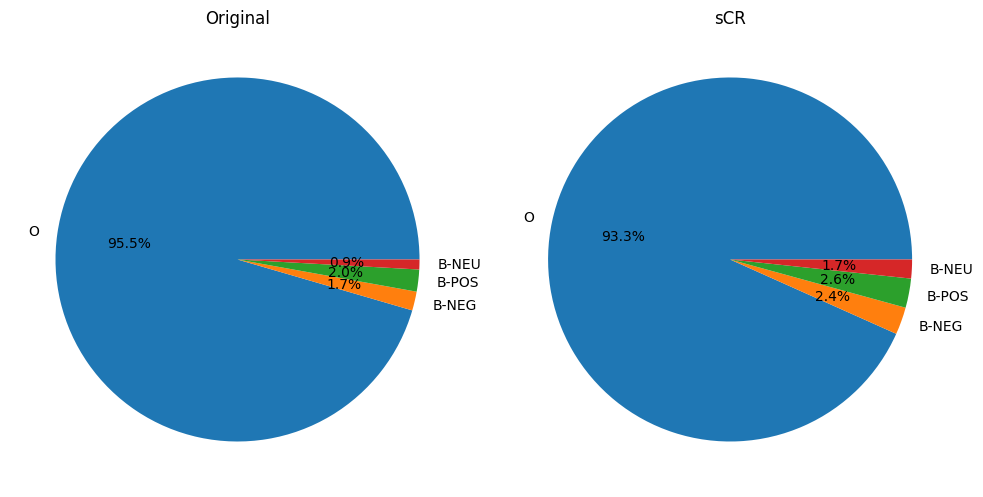

In [116]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(tags_per_scr_ds.loc['original'], labels=tags_per_scr_ds.columns, autopct='%1.1f%%')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.pie(tags_per_scr_ds.loc['sCR'], labels=tags_per_scr_ds.columns, autopct='%1.1f%%')
plt.title('sCR')

plt.tight_layout()
plt.show()


In [117]:
import copy

scr_tds = Dataset.from_pandas(sCR_df[['tokens','tags_idx','tags']], features=ds['train'].features, preserve_index=False)
scr_ds = copy.copy(ds)
scr_ds['train'] = scr_tds

print(scr_ds)
print(ds)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 95286
    })
    validation: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 911
    })
    test: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 800
    })
})
DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 2125
    })
    validation: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 911
    })
    test: Dataset({
        features: ['tokens', 'tags_idx', 'tags'],
        num_rows: 800
    })
})


## 6.5. <a id='toc6_5_'></a>[Model tuning](#toc0_)

In [111]:
class ModelTuning:
  def __init__(self, pretrained_model_name, index2tag, tag2index, y_validation=None, modelPerformanceLog=None):
    
    self.pretrained_model_name = pretrained_model_name
    self.index2tag = index2tag
    self.tag2index = tag2index

    self.pretrained_model_config = AutoConfig.from_pretrained(pretrained_model_name, 
                                        num_labels=len(self.index2tag),
                                        id2label=index2tag, label2id=tag2index)
    
    if modelPerformanceLog != None:
      self.modelPerformanceLog = modelPerformanceLog
    else:
      self.modelPerformanceLog = ModelPerformanceLog(y_validation)

  def model_init(self, architecture, loss_token_weights):
    return (DistilBertForABSA
            .from_pretrained(self.pretrained_model_name, config=self.pretrained_model_config, architecture=architecture, loss_token_weights=loss_token_weights)
            .to(device))
  
  def align_predictions(self, predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                index2tag = self.pretrained_model_config.id2label.copy()
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

  # Define performance metrics
  def compute_metrics(self, eval_pred):
    y_pred, y_true = self.align_predictions(eval_pred.predictions, 
                                        eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred, average='macro')}

  def forward_pass_with_label(self,data_collator, trainer, batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model.to(device)(input_ids, attention_mask)

        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, tags.num_classes), 
                          labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

  def tokenize_and_align_labels(self, tokenizer, examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["tags_idx"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs
  
  def encode_dataset(self, tokenizer, corpus):
    return corpus.map(lambda examples: self.tokenize_and_align_labels(tokenizer, examples), 
                      batched=True, 
                      remove_columns=['tags_idx', 'tokens','tags']
                      )
     
  def fine_tune_model(self, ds, model_name, architecture, num_epochs=6, batch_size=32, weight_decay=0.01, loss_token_weights=None):

    
    # Define tokenizer
    pretrained_tokenizer = AutoTokenizer.from_pretrained(self.pretrained_model_name)

    # Define data collator for data batching 
    data_collator = DataCollatorForTokenClassification(pretrained_tokenizer)

    ds_encoded = self.encode_dataset(pretrained_tokenizer, ds)

    logging_steps = len(ds_encoded['train']) // batch_size
    model_name_ = f"{model_name}_{architecture}_e{num_epochs}_ld{re.sub(r'[^0-9]+','',str(weight_decay))}_b{batch_size}_w{'T' if len(loss_token_weights) > 0 else 'F'}"
    
    print('Training model: ', model_name_)
    training_args = TrainingArguments(output_dir="model/logs/" + model_name_
                                      ,log_level="error"
                                      ,num_train_epochs=num_epochs
                                      ,per_device_train_batch_size=batch_size
                                      ,per_device_eval_batch_size=batch_size
                                      ,evaluation_strategy="epoch"
                                      ,save_steps=1e6
                                      ,weight_decay=weight_decay
                                      ,disable_tqdm=True
                                      ,logging_steps=logging_steps
                                      ,push_to_hub=False)
    
    trainer = Trainer(model_init=lambda: self.model_init(architecture, loss_token_weights)
                      ,args=training_args
                      ,data_collator=data_collator
                      ,compute_metrics=self.compute_metrics
                      ,train_dataset=ds_encoded["train"]
                      ,eval_dataset=ds_encoded["validation"]
                      ,tokenizer=pretrained_tokenizer)
    
    trainer.train()
    # self.trainer = trainer

    trainer_res_df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss','eval_f1']]
    trainer_res_df = trainer_res_df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", 'eval_f1':'F1'})
    trainer_res_df['Epoch'] = trainer_res_df["Epoch"].apply(lambda x: round(x))
    trainer_res_df['Training Loss'] = trainer_res_df["Training Loss"].ffill()
    trainer_res_df[['Validation Loss', 'F1']] = trainer_res_df[['Validation Loss', 'F1']].bfill().ffill()
    trainer_res_df = trainer_res_df.drop_duplicates()
    self.modelPerformanceLog.add_bert_training_epoch_history(model_name_, trainer_res_df)

    validation_set = ds_encoded["validation"]
    validation_set = validation_set.map(lambda batch: self.forward_pass_with_label(data_collator, trainer, batch), batched=True, batch_size=32)
    df_validation = validation_set.to_pandas()

    # Cleanup & conver id2text 
    index2tag = trainer.model.config.id2label.copy()
    index2tag[-100] = "IGN"
    df_validation["input_tokens"] = df_validation["input_ids"].apply(
        lambda x: pretrained_tokenizer.convert_ids_to_tokens(x))
    df_validation["predicted_label_txt"] = df_validation["predicted_label"].apply(
        lambda x: [index2tag[i] for i in x])
    df_validation["labels_txt"] = df_validation["labels"].apply(
        lambda x: [index2tag[i] for i in x])
    df_validation['loss'] = df_validation.apply(
        lambda x: x['loss'][:len(x['input_ids'])], axis=1) # Remove padding tokens
    df_validation['predicted_label'] = df_validation.apply(
        lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1) # Remove padding tokens
    df_validation['predicted_label_txt'] = df_validation.apply(
        lambda x: x['predicted_label_txt'][:len(x['input_ids'])], axis=1) # Remove padding tokens
    df_validation['labels_txt'] = df_validation.apply(
        lambda x: x['labels_txt'][:len(x['input_ids'])], axis=1) # Remove padding tokens


    # Flatten the outputs
    df_tokens = df_validation.apply(pd.Series.explode)
    df_tokens = df_tokens.query("labels != 'IGN'")
    df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)

    df_validation_metrics = df_validation.copy()

    df_validation_metrics['predicted_label_txt'] = df_validation_metrics.apply(lambda x: [x['predicted_label_txt'][i] for i,k in enumerate(x['labels_txt']) if k != 'IGN' ], axis=1)
    df_validation_metrics[['input_tokens','predicted_label_txt']].to_csv('model/predictions/'+ model_name_ +'.csv')

    self.modelPerformanceLog.add_model_performance(model_name_,df_validation_metrics['predicted_label_txt'])

    trainer.save_model('model/saved/bert_'+ model_name_)
    return model_name_, df_validation, df_tokens

## 6.6. <a id='toc6_6_'></a>[Start tuning](#toc0_)

In [112]:
pretrained_model_name = "distilbert-base-uncased"
tags = ds['train'].features['tags_idx'].feature
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

y_val = ds['validation'].to_pandas()['tags_idx']
y_val = [[index2tag[tag] for tag in sent] for sent in y_val]

modelTuning = ModelTuning(pretrained_model_name, index2tag, tag2index, y_val, modelPerformanceLog)
# modelTuning.modelPerformanceLog.get_logs()

In [113]:
def run_scenarios(model_idx, scenarios):
  runtime = datetime.now().strftime("%Y%m%d_%H%M")
  
  datasets = {'ori': ds
            ,'down': downsample_ds
            ,'scr': scr_ds
            ,'batch_size': 64
            }

  for scenario in scenarios:
    # Clear cache
    torch.mps.empty_cache()
    os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0' # this setting is needed to run NN on my Mac
    device = torch.device('mps') # This is required for Mac
    
    model_name_input = f"sc_{model_idx}_ds_{scenario['dataset']}"
    print('Start training: ', model_name_input)
    model_name, df_validation_predict, df_tokens_predict = modelTuning.fine_tune_model(datasets[scenario['dataset']], model_name_input, scenario['architecture'], scenario['epoch'],scenario['batch_size'],scenario['weight_decay'],[])
    model_idx += 1

  modelTuning.modelPerformanceLog.get_logs().to_csv(f'model/model_tuning_results_{runtime}.csv')  
  modelTuning.modelPerformanceLog.bert_epoch_history.to_csv(f'model/bert_epoch_history_{runtime}.csv')  

## 6.7. <a id='toc6_7_'></a>[First BERT](#toc0_)

In [177]:
runtime = datetime.now().strftime("%Y%m%d_%H%M")
model_idx = 1

dataset = ds
architecture = 'linear'
epoch = 15
batch_size = 64
weight_decay = 0.1
loss_weights = []

# Clear cache
torch.mps.empty_cache()
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0' # this setting is needed to run NN on my Mac
device = torch.device('mps') # This is required for Mac

model_name_input = f"sc_{model_idx}_ds_ori"
model_name, df_validation_predict, df_tokens_predict = modelTuning.fine_tune_model(dataset, model_name_input, architecture, epoch,batch_size,weight_decay,loss_weights)

modelTuning.modelPerformanceLog.get_logs().to_csv(f'model/model_tuning_results_{runtime}.csv')  
modelTuning.modelPerformanceLog.bert_epoch_history.to_csv(f'model/bert_epoch_history_{runtime}.csv')  

In [183]:
modelTuning.modelPerformanceLog.get_logs()

,Model,sklearn_f1_score,f1
0,random forest,0.14,0.0000
1,crf,0.14,0.0000
2,sc_1_ds_ori_linear_e15_ld01_b64_wF,0.60,0.5338


## 6.8. <a id='toc6_8_'></a>[Error analysis](#toc0_)

### 6.8.1. <a id='toc6_8_1_'></a>[Group by word token](#toc0_)

In [117]:
(
    df_tokens_predict.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,.,i,the,finger,windows,vista,battery,drive,to,system
count,109,60,74,3,5,2,3,2,46,3
mean,0.23,0.4,0.26,6.35,3.52,8.64,5.23,7.54,0.32,4.78
sum,24.67,23.95,19.31,19.04,17.61,17.29,15.69,15.07,14.85,14.34


THe first few tokens above have the highest loss mostly because they appeared quite a lot in our data (".", "i"), and their average loss were low which indicated that the model did not have trouble classifying them. But, windows, vista, battery,... are more likely to be aspect and they are very domain specific words, but have a low count which the model has trouble classifying them.

### 6.8.2. <a id='toc6_8_2_'></a>[Group by Tag ID](#toc0_)

In [186]:
(
    df_tokens_predict.groupby("labels_txt")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7
labels_txt,B-NEU,I-POS,B-NEG,I-NEG,I-NEU,B-POS,O,IGN
count,12,11,37,23,10,40,1399,3008
mean,5.14,4.67,4.03,3.94,3.55,3.46,0.29,0.0
sum,61.64,51.38,148.99,90.58,35.5,138.58,403.96,0.0


"NEU" both for "B" & "I" tags have the highest average loss which suggested the model may have trouble recognizing labels that may not have a very strong sentiment or no sentiment was expressed. We may re-consider whether "NEU" is a category we may want to include in our result.

In [188]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [189]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

### 6.8.3. <a id='toc6_8_3_'></a>[Sentence](#toc0_)

In [198]:
pd.set_option('display.max_rows', 500)

def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels_txt"][i])
                preds.append(row["predicted_label_txt"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df_validation_predict["total_loss"] = df_validation_predict["loss"].apply(sum)
df_tmp = df_validation_predict.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample.T)
     

,tokens,labels,preds,losses
0,i,O,O,0.00
1,can,O,O,0.01
2,render,O,O,0.25
3,av,O,O,0.01
4,##ch,IGN,O,-0.00
5,##d,IGN,O,-0.00
6,movies,O,O,0.86
7,with,O,O,0.00
8,little,O,O,0.00
9,effort,O,O,1.40


,tokens,labels,preds,losses
0,who,O,O,0.00
1,could,O,O,1.11
2,n,O,I-POS,2.55
3,',IGN,O,-0.00
4,t,IGN,O,-0.00
5,love,O,O,1.09
6,a,O,O,1.67
7,dvd,B-POS,B-NEG,2.34
8,burn,I-POS,I-NEG,2.54
9,##er,IGN,B-POS,-0.00


,tokens,labels,preds,losses
0,if,O,O,0.00
1,internet,B-NEU,I-NEG,1.83
2,connectivity,I-NEU,O,2.69
3,is,O,O,0.00
4,important,O,O,0.00
5,i,O,O,1.25
6,would,O,I-NEU,2.02
7,recommend,O,O,0.81
8,going,O,O,0.05
9,with,O,O,0.03


It seems like there could be some inconsistent annotations/ tagging strategy in the dataset. In some sentences, aspect only include the main nouns, while in other sentences ("component"), the aspect include the whole compound nouns ("quality component") which may have confused the model on which strategy to follow. I believe retraining the model on an automated label dataset will perform better as we cann avoid this inconsistency.

Also, another issues that the model may have learned by heart the exact words that are aspects and re-apply that on other sentences without reconsider the lexical of the new sentence.

## 6.9. <a id='toc6_9_'></a>[Tuning BERT](#toc0_)

I am tuning the model on 3 main components:
- Data resampling technique
  - Original
  - Down sample
  - Upsampling (sCR)
- Model architecture
  - Single linear layer
  - Double linear layer
  - BiLSTM layer
- Weighted loss

Other than these main components, I also tried a few other approach for tuning each model by adjusting some of the parameters:
- learning decay
- batch size
- number of epochs

All of the training scenario can be configure using the scenarios variable as below.

Due tosome technical issues, I have lost some of my training scenarios' results which includes a model that uses XML-Roberta instead of DistilBERT model that outperform all of these model. It has been pushed to HugginFace hub at this <a href='https://huggingface.co/tnatvu/xlm-roberta-base-absa/'>link</a>. However, I was able to re-run and save some key models' results as below.

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [209]:
pd.read_csv('model/model_tuning_results_20240205_0113.csv')

,Unnamed: 0,sklearn_f1_score,f1
0,random forest,0.14,0.0000
1,crf,0.14,0.0000
2,sc_1_ds_ori_linear_e15_ld01_b64_wF,0.60,0.5338
3,sc_10_ds_down_linear_e15_ld01_b64_wF,0.62,0.5491
4,sc_100_ds_down_additional_linear_e50_ld01_b64_wF,0.42,0.3460
5,sc_101_ds_down_lstm_e70_ld01_b64_wF,0.14,0.0000
6,sc_10000_ds_down_additional_linear_e100_ld05_b512_wF,0.14,0.0000
7,sc_10000_ds_down_additional_linear_e150_ld01_b64_wF,0.57,0.4807
8,sc_10001_ds_down_lstm_e300_ld01_b64_wF,0.33,0.3333
9,sc_100000_ds_scr_linear_e10_ld01_b128_wF,0.59,0.5562


Some of the learnings from these experiments are:

**Data sampling:**

The experiments showed that using the same architecture (single linear layer) applying upsampling/ downsampling techniques improved the model's performance slightly. Given how imbalance the dataset is, there may be more opportunities to experiment with different sampling techniques to achieve a better results.

**Architecture:**

The more complex the architecture is, the more epochs it needs to achieve the same results. However, it may still provide a slight improvement in the model performance. It took "2 linear layer" model 50 epochs and still perform worse than "single linear layer". Similarly, "Bi-LSTM" required with more than 600 epochs still scored just around 0.20 in coNLL F1 score, way below "single linear" model. 
In general, unlesss there is a requirement to maximize model's prediction power, opting for a simpler architecture can significantly speed up training time.

**Weighted loss:**

I could not re-produced this intime, but from my experiments, weighted loss also provide a slight increase in model performance.


### 6.9.1. <a id='toc6_9_1_'></a>[Different datasets](#toc0_)

In [78]:
model_idx = 10 #this is just to keep track of the scenario batch run
scenarios = [
            {'dataset': 'ori'
             ,'epoch': 15
             ,'architecture': 'linear'
             ,'weight_decay': 0.1
             ,'batch_size': 64
            }
            
            ,{'dataset': 'down'
             ,'epoch': 15
             ,'architecture': 'linear'
             ,'weight_decay': 0.1
             ,'batch_size': 64
            }

            ,{'dataset': 'scr'
             ,'epoch': 15
             ,'architecture': 'linear'
             ,'weight_decay': 0.1
             ,'batch_size': 64
            }
            ]

run_scenarios(model_idx, scenarios)

### 6.9.2. <a id='toc6_9_2_'></a>[Architecture](#toc0_)

In [ ]:
model_idx = 10000 #this is just to keep track of the scenario batch run
scenarios = [
            {'dataset': 'down'
             ,'epoch': 150
             ,'architecture': 'additional_linear'
             ,'weight_decay': 0.1
             ,'batch_size': 64
            }
            
            ,{'dataset': 'down'
             ,'epoch': 650
             ,'architecture': 'lstm'
             ,'weight_decay': 0.1
             ,'batch_size': 64
            }
            ]

run_scenarios(model_idx, scenarios)

### 6.9.3. <a id='toc6_9_3_'></a>[Tuning learning decay & batch size](#toc0_)

In [79]:
model_idx = 100000 # this is just to keep track of the scenario batch run
scenarios = [
            {'dataset': 'down'
             ,'epoch': 800
             ,'architecture': 'lstm'
             ,'weight_decay': 0.1
             ,'batch_size': 64
            }

            ]

run_scenarios(model_idx, scenarios)

In [ ]:
modelTuning.modelPerformanceLog.get_logs()